---

---


# Tutorial 4: Automated Face Analysis

<ins>**Objectives:**</ins>

- **face detection**: you'll learn how to detect faces in images, and extract
  and save each face as a separate image file for further analysis.

- **face recognition**: you'll learn how to recognize particular faces of
  interest in your set of detected images (e.g. a particular politician, media
  figure, etc).

- **face analysis**: you'll learn how to extract additional features from the
  detected faces, such as their gender, race, age and expressed emotions.

<ins>**Datasets:**</ins>

- **small celebrity dataset**: a dataset with some sample pictures of 5
  celebrities (Mindy Kaling, Madonna, Jerry Seinfeld, Elton John, and Ben
  Affleck). For each of the celebrities we have about 14-20 train images, and 5
  validation ones. These have not been cropped, so sometimes there is full body,
  not only the cropped face. I obtained the dataset from Kaggle:
  https://www.kaggle.com/dansbecker/5-celebrity-faces-dataset

<ins>**Key module/s:**</ins>

- **DeepFace**: an open-source module to perform many face-related tasks and
  that builds on many other existing modules. So basically, in one module you
  have many tools that used to be spread in different modules, super convinent!
  In addition, through this model you can already access and use many
  face-related pre-trained models. Again, very convinient! You can find more
  info here: https://github.com/serengil/deepface

- **face-recognition**: unfortunately, **DeepFace** doesn't do a great job at
  detecting > 1 face in a given image. This module has better face-detection
  capabilities. You can find more info here:
  https://github.com/ageitgey/face_recognition


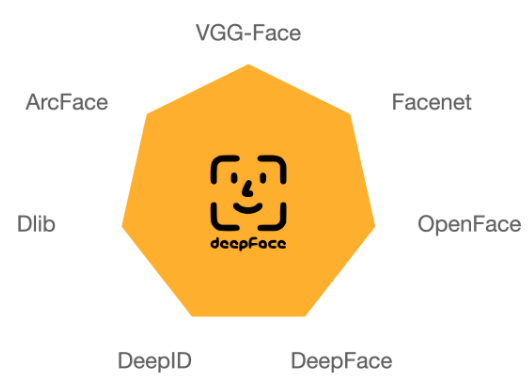


---

---


## 0. Install the packages/modules that we'll be using. Set up GPU.

These google-colab notebooks allow us to run code in virtual machines located
elsewhere. Every time we start a session, the virtual machine is "empty", so
non-native python modules need to be installed. Let's install the ones we'll
need in this particular notebook. We'll do so using `pip` and the `!` marker
that allows us to run `bash` code in the same notebook.


In [1]:
# - before getting started, set up GPU.
import tensorflow as tf

# - get the GPU device name.
device_name = tf.test.gpu_device_name()

# - the device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [2]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566171 sha256=2ca41956b91637ad2b343f2a9c91fb4b4e64eaaf50e9249886affd0174354aaf
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [3]:
!pip install deepface

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 9.8 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.5.0-py2.py3-none-any.whl size=116934 sha256=17594e0b446138a795dc1ecc4119e0d1f22465bd38363164c0b3bec2ea3760ef
  Stored in directory: /root/.cache/pip/wheels/90/d4/f7/9404e5db0116bd4d43e5666eaa3e70ab53723e1e3ea40c9a95
Successfully built fire


## 1. Load the modules that we'll be using


In [4]:
from google.colab import drive # module to mount the google drive
import face_recognition # face detection
from deepface import DeepFace # face recognition/feature-analysis
import os # to operate with the system
import cv2 # to manipulate images
from matplotlib import pyplot as plt # for plotting and showing images
from PIL import Image, ImageOps # also for image manipulation
import random
import numpy as np
from IPython.display import Image as Ipyimage

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


## 2. Mount the Google Drive for the workshop to this virtual machine


In [5]:
# - it will generate a url. Click on it, specify the google account you want to
#   use, and
drive.mount("/content/gdrive")

Mounted at /content/gdrive


## 3. Declare the data path


In [6]:
data_path = '/content/'

## 4. Face detection

Before running any face analysis, we first need to:

- detect where in a given image there is a face
- draw a box around the image
- crop the face
- save it as a separate image file for further anlaysis

Let's practice with the `train` images in the `small celebrity dataset`!


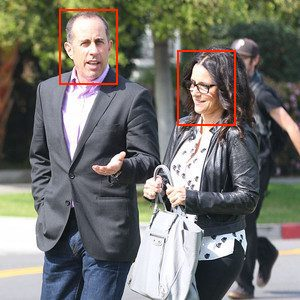


In [7]:
# - path to the "train" directory of the small-celeb-dataset
celeb_train = '{}small-celeb-data/train/'.format(data_path)

# - a list of the 5 celebrity directories in there
celebrities = os.listdir(celeb_train)

# - take a look at the list of celebrities
celebrities

['madonna', 'elton_john', 'ben_afflek', 'mindy_kaling', 'jerry_seinfeld']

In [8]:
# - let's first play with a single image
oneimg_fname = '{}jerry_seinfeld/httpwwweonlinecomresizewwweonlinecomeolimagesEntireSitersxjerryseinfeldjulialouisdreyfusjwjpg.jpg'.format(
    celeb_train)

# - load and print/take-a-look at the image
img = Image.open(oneimg_fname)

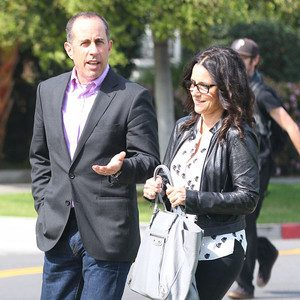

In [9]:
img

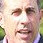

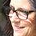

In [10]:
# - perform face detection.
img_torecogn = face_recognition.load_image_file(oneimg_fname)
face_locations = face_recognition.face_locations(
    img_torecogn)

for coord_set in face_locations:
  # - resort the 4-coord to fit the PIL.Image specification:
  #   (left, top, right, bootm)
  newcoord_set = (coord_set[3], coord_set[0],
                  coord_set[1], coord_set[2])
  # - take a look at the cropped faces
  display(img.crop(newcoord_set))

In [11]:
# - now let's do the same for all the images in the "train" set. Let's also save
#   the cropped images in a folder so we can load them and use them for further
#   analysis when needed. First, we'll create a folder for each of us in the
#   output directory, so we can clearly see the output each of us is writing out.

output_path = '/content/output/'
output_path02 = '{}cropped_faces/'.format(output_path)
if not os.path.isdir(output_path02):
  os.mkdir(output_path02)

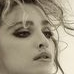

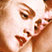

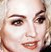

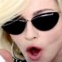

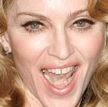

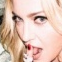

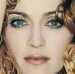

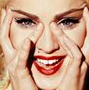

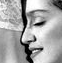

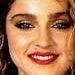

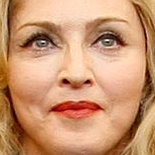

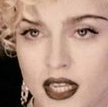

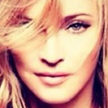

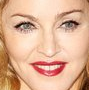

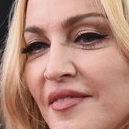

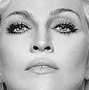

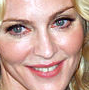

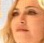

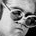

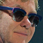

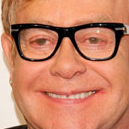

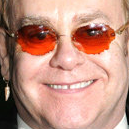

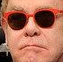

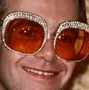

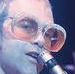

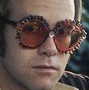

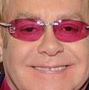

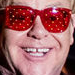

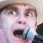

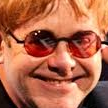

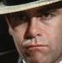

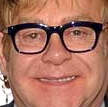

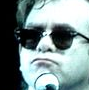

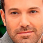

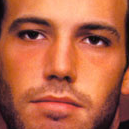

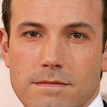

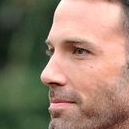

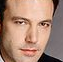

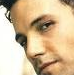

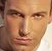

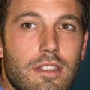

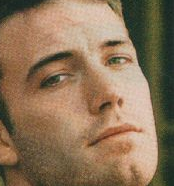

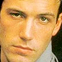

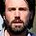

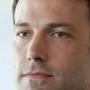

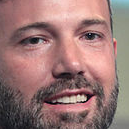

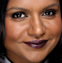

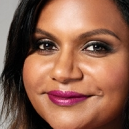

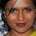

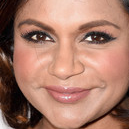

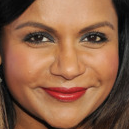

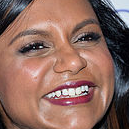

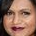

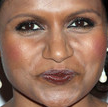

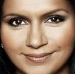

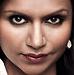

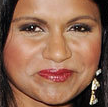

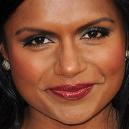

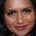

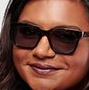

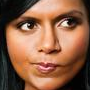

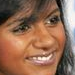

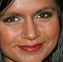

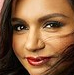

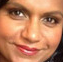

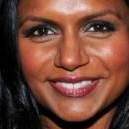

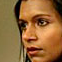

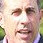

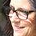

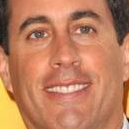

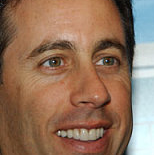

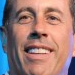

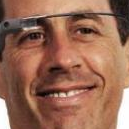

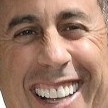

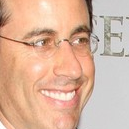

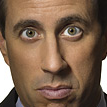

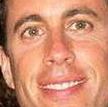

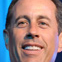

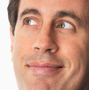

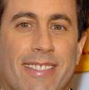

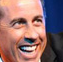

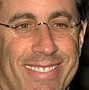

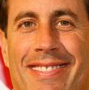

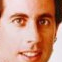

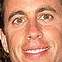

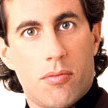

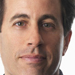

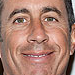

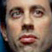

In [12]:
# - iterate through the celebrity folders and their images to perform the face
#   detection
for celebrity in celebrities:
  # - path to the train directory for that celebrity
  celeb_path = '{}{}/'.format(celeb_train, celebrity)
  # - list all the image files in there
  celeb_imgfiles = os.listdir(celeb_path)
  # - iterate through the images
  for imgfile in celeb_imgfiles:
    # - load the img
    imgpath = '{}{}'.format(celeb_path, imgfile)
    img = Image.open(imgpath)
    # - perform the face detection
    img_torecogn = face_recognition.load_image_file(imgpath)
    face_locations = face_recognition.face_locations(
        img_torecogn)
    face_count = 0
    for coord_set in face_locations:
      face_count += 1
      # - resort the 4-coord to fit the PIL.Image specification:
      #   (left, top, right, bootm)
      newcoord_set = (coord_set[3], coord_set[0],
                      coord_set[1], coord_set[2])
      # - take a look at the cropped faces
      cropped_img = img.crop(newcoord_set)
      display(cropped_img)
      # - save the image
      outname = '{}/{}__face{}_{}'.format(
          output_path02, celebrity, face_count, imgfile)
      # ... some of these images have 4 dimensions (additional 'alpha' dim),
      #     getting rid of it when needed it's there so we can save it as jpeg.
      if np.array(cropped_img).shape[2]:
        cropped_img = cropped_img.convert('RGB')
      cropped_img.save(outname, format = "JPEG")

## 5. Face Recognition

### 5.1 Match to reference images


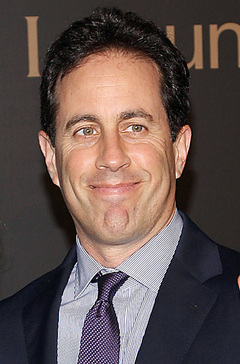

In [13]:
# - let's use pre-trained models to see if we can find images of a particular
#   person in our pool of cropped images, using a reference image

# - we'll use a reference image from the "val" set
ref_imgpath = '{}small-celeb-data/val/jerry_seinfeld/httpblognjcomentertainmentimpactcelebritiesmediumjerrybjpg.jpg'.format(
    data_path)

ref_img = Image.open(ref_imgpath)
ref_img

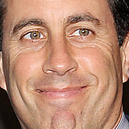

In [14]:
# - crop the face of the reference image, so get the reference face
img_torecogn = face_recognition.load_image_file(ref_imgpath)
coord_set = face_recognition.face_locations(
    img_torecogn)[0]
# - resort the 4-coord to fit the PIL.Image specification:
#   (left, top, right, bootm)
newcoord_set = (coord_set[3], coord_set[0],
                coord_set[1], coord_set[2])
# - take a look at the cropped face
ref_face = ref_img.crop(newcoord_set)
display(ref_face)
# - save the reference image
ref_outname = '{}/ref_face.jpg'.format(output_path)
ref_face.save(ref_outname, format = "JPEG")

In [15]:
# - compare all the faces we previously cropped to this reference face image, to
#   see if the pre-trained model finds additional instances/images. Let's first
#   start with one of the pre-trained models available on DeepFace. Then we'll
#   use them all to see which one is more accurate.
#   /!\ The first time one of these models is used, the pre-trained version gets
#   automatically downloaded, which make take a few seconds/minutes.
recognition = DeepFace.find(
      # ... path to the reference iamge
      img_path = ref_outname,
      # ... path to the pool of cropped images
      db_path = output_path02,
      # ... pre-trained model to use
      model_name = "VGG-Face", # using "VGG-Face"
      enforce_detection = False)[0]

# - delete "representations" file saved by the DeepFace.find() function
flist = os.listdir(output_path02)
repr_file = [x for x in flist if 'representations' in x][0]
os.remove('{}{}'.format(output_path02, repr_file))

Finding representations:   0%|          | 0/89 [00:00<?, ?it/s]

vgg_face_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/vgg_face_weights.h5
To: /root/.deepface/weights/vgg_face_weights.h5

  0%|          | 0.00/580M [00:00<?, ?B/s]
  0%|          | 1.05M/580M [00:00<01:06, 8.65MB/s]
  0%|          | 2.62M/580M [00:00<00:47, 12.2MB/s]
  1%|          | 5.24M/580M [00:00<00:33, 17.4MB/s]
  2%|▏         | 9.44M/580M [00:00<00:22, 25.5MB/s]
  3%|▎         | 15.2M/580M [00:00<00:15, 35.8MB/s]
  4%|▍         | 24.1M/580M [00:00<00:10, 52.7MB/s]
  7%|▋         | 37.7M/580M [00:00<00:06, 78.5MB/s]
 10%|█         | 58.2M/580M [00:00<00:04, 117MB/s] 
 14%|█▍        | 81.8M/580M [00:00<00:03, 152MB/s]
 18%|█▊        | 106M/580M [00:01<00:02, 179MB/s] 
 22%|██▏       | 129M/580M [00:01<00:02, 194MB/s]
 26%|██▋       | 153M/580M [00:01<00:02, 206MB/s]
 30%|███       | 176M/580M [00:01<00:01, 213MB/s]
 34%|███▍      | 200M/580M [00:01<00:01, 218MB/s]
 38%|███▊      | 223M/580M [00:01<00:01, 221MB/s]
 42%|████▏     | 246M/580M [00:0

Representations stored in /content/gdrive/MyDrive/images-as-data-workshop-gesis/output/cropped_faces//representations_vgg_face.pkl file.Please delete this file when you add new identities in your database.
find function lasts  27.94342017173767  seconds


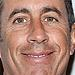

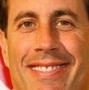

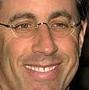

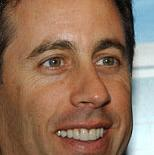

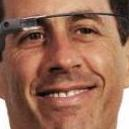

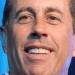

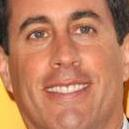

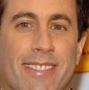

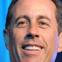

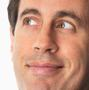

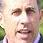

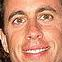

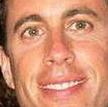

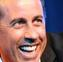

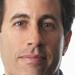

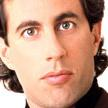

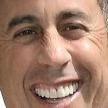

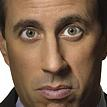

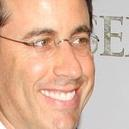

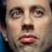

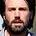

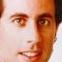

In [16]:
# - check which images have been matched to our reference face. Usually these
#   models use a similarity threshold of < 0.4 to determine a match.
matched_imgs = recognition[recognition['VGG-Face_cosine'] < 0.4]
for i in range(len(matched_imgs)):
  img = Image.open(matched_imgs['identity'].iloc[i])
  display(img)

In [17]:
# - assess ACCURACY. Let's build a function for this so we can re-use it when
#   checking out how well the performance of the other pre-trained models.
def get_accuracy(outpath, model, matched_imgs):
  all_faces = os.listdir(output_path02)
  # ... a list of the images that we know are of jerry_seinfeld
  jerry_faces = [x for x in all_faces if "seinfeld" in x and
                # ... this is the one we know is not of Jerry (but Elaine)
                x != "jerry_seinfeld__face1_httpwwweonlinecomresizewwweonlinecomeolimagesEntireSitersxjerryseinfeldjulialouisdreyfusjwjpg.jpg"]
  jerry_notfaces = set(all_faces).difference(jerry_faces)
  # ... a list of the ones the model matched to our reference Seinfeld face
  jerry_predicted = [x.split('/')[8] for x in list(matched_imgs['identity'])]
  # ... a list of the ones NOT matched by the model
  jerry_notpredicted = set(all_faces).difference(jerry_predicted)
  # ... a list of the correctly predicted ones
  correct_positives = set(jerry_faces).intersection(set(jerry_predicted))
  correct_negatives = set(jerry_notfaces).intersection(jerry_notpredicted)
  correct_predictions = correct_positives.union(correct_negatives)
  print('Model: {}'.format(model))
  print('Accuracy {} | Precision {} | Recall {}'.format(
  # - Accuracy: Prop. of correct predictions
  round(len(correct_predictions) / len(all_faces),3),
  # - Precision: Prop. of times that the model matched Seinfeld and it was
  #              actually him
    round(len(correct_positives) / len(jerry_predicted),3),
  # - Recall: Prop. of images we know are about Seinfeld and that were ineed
  #           matched by the model
  round(len(correct_positives) / len(jerry_faces), 3)
  ))

In [18]:
get_accuracy(output_path02, 'VGG-Face', matched_imgs)

Model: VGG-Face
Accuracy 0.966 | Precision 0.909 | Recall 0.952


In [19]:
# - try out the other pre-trained models and check how well they perform
models = ["VGG-Face",
          "Facenet",
          "Facenet512",
          #"OpenFace", #(having some issues w. OpenFace)
          #"DeepFace",
          #"DeepID",
          "Dlib",
          "ArcFace",
          #"SFace"
          ]


for model in models:
  # - run the pre-trained model
  recognition = DeepFace.find(
      # ... path to the reference iamge
      img_path = ref_outname,
      # ... path to the pool of cropped images
      db_path = output_path02,
      # ... pre-trained model to use
      model_name = model, # using different pre-trained models
      enforce_detection = False)[0]
  # - delete "representations" file saved by the DeepFace.find() function
  flist = os.listdir(output_path02)
  repr_file = [x for x in flist if 'representations' in x][0]
  os.remove('{}{}'.format(output_path02, repr_file))
  matched_imgs = recognition[recognition[recognition.columns[1]] < 0.4]
  # - check accuracy
  get_accuracy(output_path02, model, matched_imgs)
  print('\n\n')

Finding representations: 100%|██████████| 89/89 [00:14<00:00,  6.35it/s]


Representations stored in /content/gdrive/MyDrive/images-as-data-workshop-gesis/output/cropped_faces//representations_vgg_face.pkl file.Please delete this file when you add new identities in your database.
find function lasts  14.347918510437012  seconds
Model: VGG-Face
Accuracy 0.966 | Precision 0.909 | Recall 0.952





Finding representations:   0%|          | 0/89 [00:00<?, ?it/s]

facenet_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet_weights.h5
To: /root/.deepface/weights/facenet_weights.h5

  0%|          | 0.00/92.2M [00:00<?, ?B/s]
  1%|          | 1.05M/92.2M [00:00<00:10, 8.35MB/s]
  3%|▎         | 3.15M/92.2M [00:00<00:06, 13.4MB/s]
  7%|▋         | 6.29M/92.2M [00:00<00:04, 19.7MB/s]
 12%|█▏        | 11.0M/92.2M [00:00<00:02, 29.2MB/s]
 20%|█▉        | 18.4M/92.2M [00:00<00:01, 43.3MB/s]
 32%|███▏      | 29.4M/92.2M [00:00<00:00, 63.9MB/s]
 50%|█████     | 46.1M/92.2M [00:00<00:00, 95.3MB/s]
100%|██████████| 92.2M/92.2M [00:00<00:00, 95.3MB/s]
Finding representations: 100%|██████████| 89/89 [00:17<00:00,  5.07it/s]


Representations stored in /content/gdrive/MyDrive/images-as-data-workshop-gesis/output/cropped_faces//representations_facenet.pkl file.Please delete this file when you add new identities in your database.
find function lasts  17.72774910926819  seconds
Model: Facenet
Accuracy 0.944 | Precision 1.0 | Recall 0.762





Finding representations:   0%|          | 0/89 [00:00<?, ?it/s]

facenet512_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facenet512_weights.h5
To: /root/.deepface/weights/facenet512_weights.h5

  0%|          | 0.00/95.0M [00:00<?, ?B/s]
  1%|          | 1.05M/95.0M [00:00<00:10, 9.37MB/s]
  3%|▎         | 3.15M/95.0M [00:00<00:06, 14.1MB/s]
  7%|▋         | 6.29M/95.0M [00:00<00:04, 20.2MB/s]
 12%|█▏        | 11.0M/95.0M [00:00<00:02, 29.2MB/s]
 19%|█▉        | 18.4M/95.0M [00:00<00:01, 43.2MB/s]
 31%|███▏      | 29.9M/95.0M [00:00<00:00, 65.7MB/s]
 50%|█████     | 47.7M/95.0M [00:00<00:00, 99.9MB/s]
100%|██████████| 95.0M/95.0M [00:00<00:00, 98.7MB/s]
Finding representations: 100%|██████████| 89/89 [00:15<00:00,  5.62it/s]


Representations stored in /content/gdrive/MyDrive/images-as-data-workshop-gesis/output/cropped_faces//representations_facenet512.pkl file.Please delete this file when you add new identities in your database.
find function lasts  16.00947117805481  seconds
Model: Facenet512
Accuracy 0.899 | Precision 1.0 | Recall 0.571





Finding representations:   0%|          | 0/89 [00:00<?, ?it/s]

dlib_face_recognition_resnet_model_v1.dat is going to be downloaded


Downloading...
From: http://dlib.net/files/dlib_face_recognition_resnet_model_v1.dat.bz2
To: /root/.deepface/weights/dlib_face_recognition_resnet_model_v1.dat.bz2

  0%|          | 0.00/21.4M [00:00<?, ?B/s]
  5%|▍         | 1.05M/21.4M [00:00<00:02, 8.37MB/s]
 24%|██▍       | 5.24M/21.4M [00:00<00:00, 25.8MB/s]
100%|██████████| 21.4M/21.4M [00:00<00:00, 57.4MB/s]
Finding representations: 100%|██████████| 89/89 [00:05<00:00, 17.50it/s]


Representations stored in /content/gdrive/MyDrive/images-as-data-workshop-gesis/output/cropped_faces//representations_dlib.pkl file.Please delete this file when you add new identities in your database.
find function lasts  5.157745122909546  seconds
Model: Dlib
Accuracy 0.955 | Precision 0.947 | Recall 0.857





Finding representations:   0%|          | 0/89 [00:00<?, ?it/s]

arcface_weights.h5  will be downloaded to  /root/.deepface/weights/arcface_weights.h5


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/arcface_weights.h5
To: /root/.deepface/weights/arcface_weights.h5

  0%|          | 0.00/137M [00:00<?, ?B/s]
  1%|          | 1.05M/137M [00:00<00:15, 8.77MB/s]
  2%|▏         | 2.62M/137M [00:00<00:11, 12.2MB/s]
  4%|▍         | 5.24M/137M [00:00<00:07, 17.5MB/s]
  7%|▋         | 9.44M/137M [00:00<00:04, 25.7MB/s]
 11%|█         | 15.2M/137M [00:00<00:03, 36.4MB/s]
 18%|█▊        | 24.1M/137M [00:00<00:02, 53.6MB/s]
 28%|██▊       | 38.3M/137M [00:00<00:01, 81.0MB/s]
 44%|████▎     | 59.8M/137M [00:00<00:00, 123MB/s] 
 62%|██████▏   | 85.5M/137M [00:00<00:00, 163MB/s]
 80%|████████  | 110M/137M [00:01<00:00, 188MB/s] 
100%|██████████| 137M/137M [00:01<00:00, 116MB/s]
Finding representations: 100%|██████████| 89/89 [00:13<00:00,  6.79it/s]


Representations stored in /content/gdrive/MyDrive/images-as-data-workshop-gesis/output/cropped_faces//representations_arcface.pkl file.Please delete this file when you add new identities in your database.
find function lasts  13.248441219329834  seconds
Model: ArcFace
Accuracy 0.978 | Precision 0.952 | Recall 0.952





### 5.2 Fine tune pre-trained model if preformance is too low

We have already looked at how to do this in Tutorial 2


## 6. Additional Face Analysis: Gender, Race, Age, and Expressed Emotions

`DeepFace` makes it very easy to pull this information from cropped faces, in a
single function!


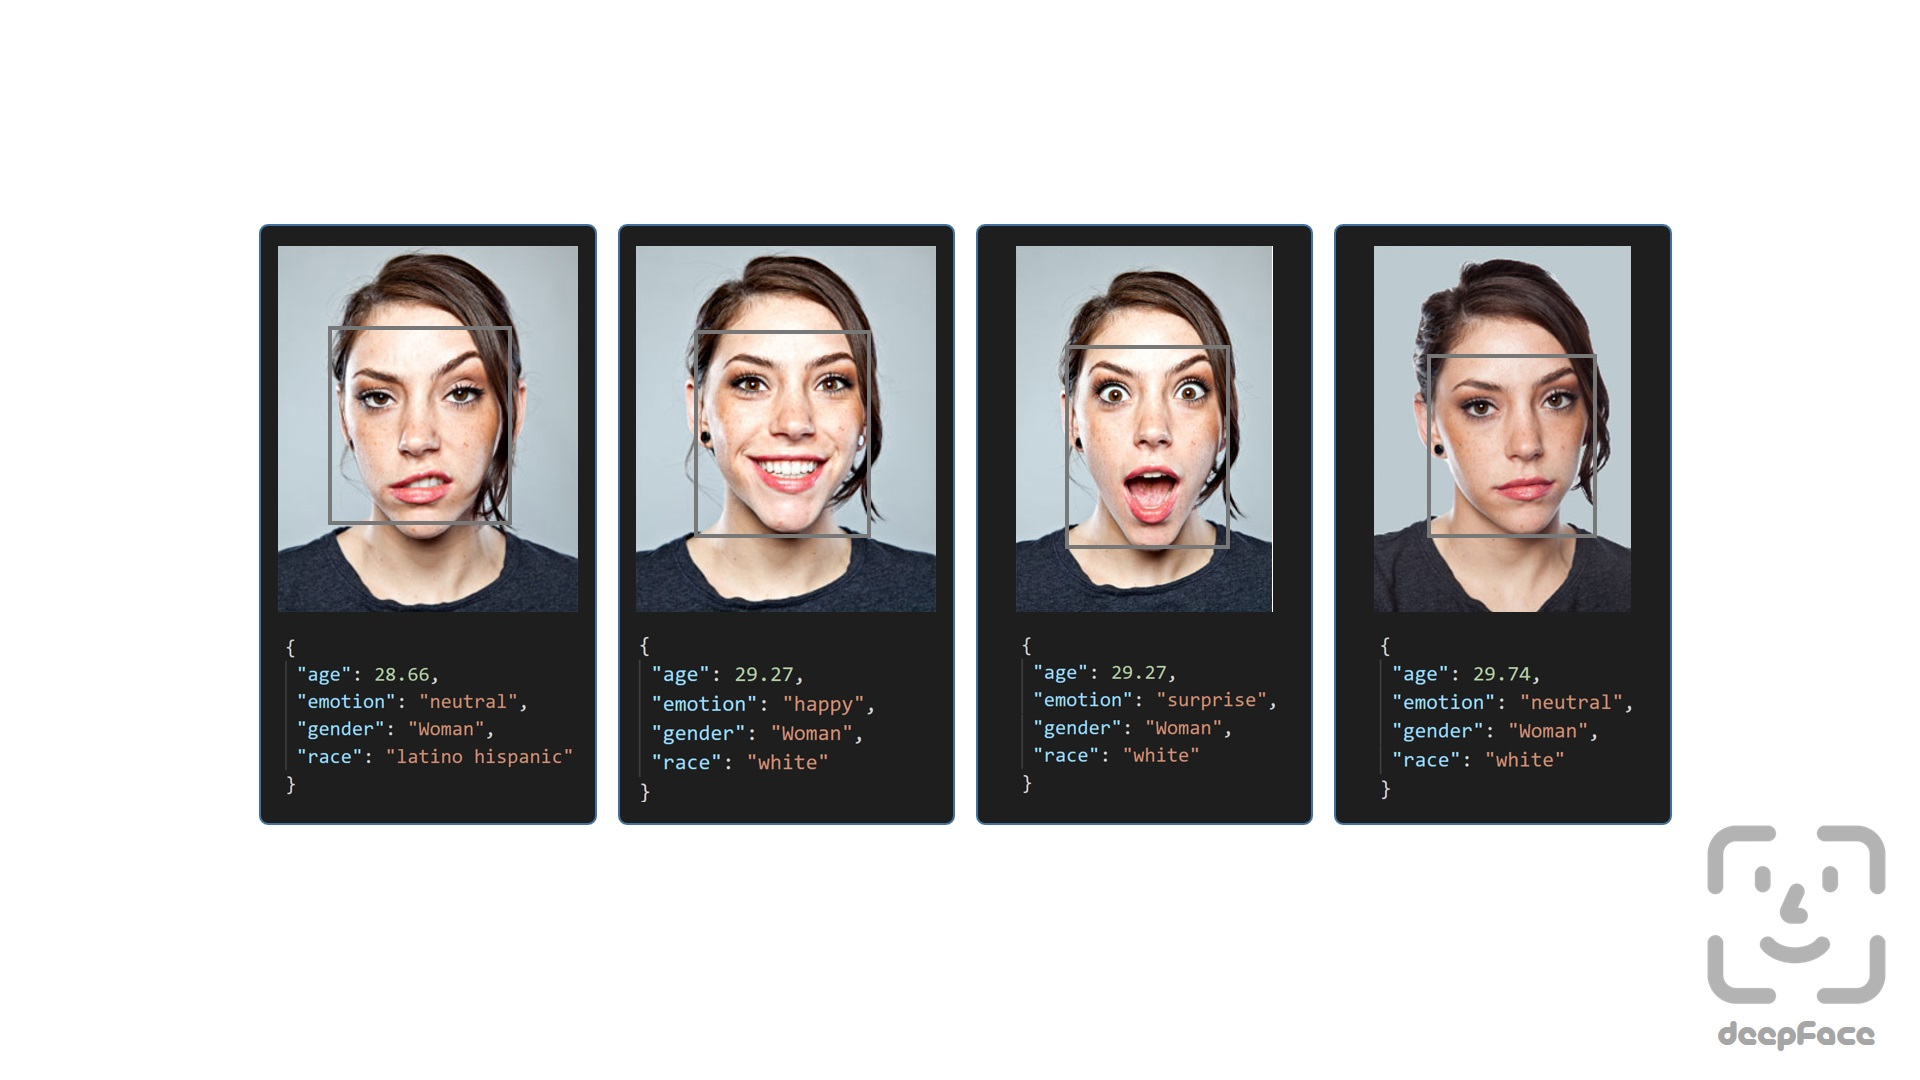


In [20]:
# - let's do a first test with a few sample images from the celebrity dataset
# ... Mindy Kaling
img01 = 'mindy_kaling__face1_httpsimagesnasslimagesamazoncomimagesIAQdwKvFILUXjpg.jpg'
# ... Jerry Seinfeld
img02 = 'jerry_seinfeld__face1_httpikinjaimgcomgawkermediaimageuploadsWmIuhdsrcedidjpgjpg.jpg'
# ... Madonna
img03 = 'madonna__face1_httpimagegaladevcmseamadonnaprivatdetektivsquaretopsquarejpgv.jpg'
# ... Ben Affleck
img04 = 'ben_afflek__face1_httpssmediacacheakpinimgcomxeeedcacddeccccacfjpg.jpg'

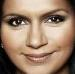

In [21]:
img01_toshow = Image.open('{}{}'.format(output_path02, img01))
img01_toshow

In [22]:
DeepFace.analyze(
    img_path = '{}{}'.format(output_path02, img01),
    actions = ['age', 'gender', 'race', 'emotion'],
    enforce_detection = False)

facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 16.7MB/s]


age_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/age_model_weights.h5
To: /root/.deepface/weights/age_model_weights.h5
100%|██████████| 539M/539M [00:02<00:00, 186MB/s]


gender_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/gender_model_weights.h5
To: /root/.deepface/weights/gender_model_weights.h5
100%|██████████| 537M/537M [00:05<00:00, 93.9MB/s]


race_model_single_batch.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/race_model_single_batch.h5
To: /root/.deepface/weights/race_model_single_batch.h5
100%|██████████| 537M/537M [00:02<00:00, 192MB/s]
Action: emotion: 100%|██████████| 4/4 [00:01<00:00,  2.99it/s]


[{'age': 23,
  'region': {'x': 0, 'y': 0, 'w': 75, 'h': 74},
  'gender': {'Woman': 99.9289870262146, 'Man': 0.07100966176949441},
  'dominant_gender': 'Woman',
  'race': {'asian': 0.43279424095417507,
   'indian': 1.3976833684851746,
   'black': 0.07967378371313415,
   'white': 49.43815764416204,
   'middle eastern': 17.58648410954977,
   'latino hispanic': 31.065209571433638},
  'dominant_race': 'white',
  'emotion': {'angry': 4.756717260079313e-05,
   'disgust': 3.5755788249918624e-12,
   'fear': 6.372740557480938e-07,
   'happy': 99.86415505409241,
   'sad': 0.0006653855052718427,
   'surprise': 1.3007757537764064e-06,
   'neutral': 0.13513126177713275},
  'dominant_emotion': 'happy'}]

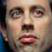

In [ ]:
img02_toshow = Image.open('{}{}'.format(output_path02, img02))
img02_toshow

In [ ]:
DeepFace.analyze(
    img_path = '{}{}'.format(output_path02, img02),
    actions = ['age', 'gender', 'race', 'emotion'],
    enforce_detection = False)

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  8.26it/s]


[{'age': 27,
  'region': {'x': 0, 'y': 0, 'w': 52, 'h': 52},
  'gender': {'Woman': 0.006229814607650042, 'Man': 99.9937653541565},
  'dominant_gender': 'Man',
  'race': {'asian': 2.4920593947172165,
   'indian': 5.341734364628792,
   'black': 0.6829730700701475,
   'white': 43.5149222612381,
   'middle eastern': 22.939595580101013,
   'latino hispanic': 25.028714537620544},
  'dominant_race': 'white',
  'emotion': {'angry': 9.704324269810233,
   'disgust': 0.0012806708290191517,
   'fear': 22.072834917644848,
   'happy': 0.002640998669595299,
   'sad': 60.4993773102018,
   'surprise': 0.0006455826083927638,
   'neutral': 7.718900021183494},
  'dominant_emotion': 'sad'}]

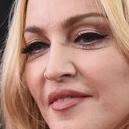

In [ ]:
img03_toshow = Image.open('{}{}'.format(output_path02, img03))
img03_toshow

In [ ]:
DeepFace.analyze(
    img_path = '{}{}'.format(output_path02, img03),
    actions = ['age', 'gender', 'race', 'emotion'],
    enforce_detection = False)

Action: emotion: 100%|██████████| 4/4 [00:00<00:00,  9.44it/s]


[{'age': 30,
  'region': {'x': 0, 'y': 0, 'w': 129, 'h': 129},
  'gender': {'Woman': 99.99885559082031, 'Man': 0.001142843484558398},
  'dominant_gender': 'Woman',
  'race': {'asian': 0.15086738593458449,
   'indian': 6.659540185900938,
   'black': 0.07794970179794442,
   'white': 40.18225611342526,
   'middle eastern': 46.71303610283351,
   'latino hispanic': 6.216352803489733},
  'dominant_race': 'middle eastern',
  'emotion': {'angry': 25.818243622779846,
   'disgust': 0.9818379767239094,
   'fear': 14.740416407585144,
   'happy': 3.3275969326496124,
   'sad': 53.27380299568176,
   'surprise': 0.08137139957398176,
   'neutral': 1.776733435690403},
  'dominant_emotion': 'sad'}]